In [6]:
## Lifelines
import glob
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from itertools import groupby
import spacy
from PIL import Image
from matplotlib.pyplot import cm
from scipy.stats import sem
import copy
import warnings

warnings.simplefilter('ignore', np.RankWarning)

nlp = spacy.load("en_core_web_sm")

titles = ['Horror', 'Adventure', 'Drama', 'Biography', 'Action', 'Fantasy', 'SciFi', 'Animation']
fit_degree = 68

In [7]:

def plot_lines(ys, title, wtp_mean, wtp_std, mean=False, word=None):
    if mean:
        ys_mean = np.stack(ys).mean(axis=0)
        ys_sem = sem(np.stack(ys), axis=0)
    else:
        ys_mean = ys

    xs = np.linspace(0, 90, num=900)

    plt.figure()

    n_lines = 15
    color = iter(cm.rainbow(np.linspace(0, 1, n_lines + 2)))
    colors = []

    for i in range(1, n_lines + 2):
        colors.append(next(color))

    plt.plot(xs, ys_mean, color=colors[n_lines], label="Original")

    if mean:
        plt.fill_between(xs, ys_mean - ys_sem, ys_mean + ys_sem, alpha=0.2)

    plt.title("Enjoyment of {} Movie Trailer Over Time\nWTP M={}, SD={}".format(title, str(wtp_mean), str(wtp_std)), )

    if wtp_std is None:
        plt.title("WTP = {}, Word = {}".format(str(wtp_mean), word), fontsize=25)
    else:
        plt.ylabel("Enjoyment")
        plt.xlabel("Time (sec)")

    plt.tight_layout()

    ax = plt.gca()
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend()
    plt.show()

    #if wtp_std is None:
    #    ax.get_xaxis().set_visible(False)
    #    plt.savefig("./plots/individual/lifeline_{}.png".format(title), dpi=50)
    #else:
    #    plt.savefig("./plots/analysis_plots/lifeline_{}.png".format(title), dpi=300)

In [ ]:
use_rpy2 = False
if use_rpy2:
    from rpy2 import robjects
    from rpy2.robjects.packages import importr

    base = importr('base')
    stats = importr('stats')

    from rpy2.robjects import pandas2ri

    pandas2ri.activate()

data = pd.read_csv('./data/data_prolific.csv')
data = data.drop(data[data.Finished != 'True'].index)
print("Number before exclusions: ", data.shape[0])
before_exc = data.shape[0]

Number before exclusions:  297
Number of participants excluded from comprehension checks:  23
Inactive participants:  58
Number after exclusions:  216
Mean age:  40.68075117370892
% Female:  0.4351851851851852


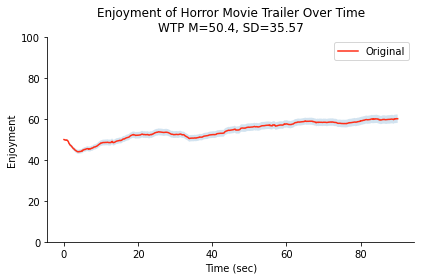

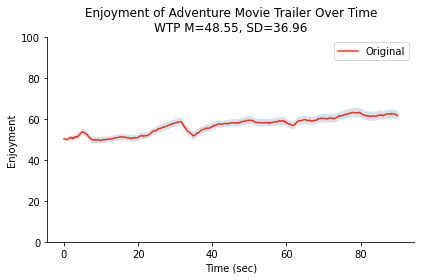

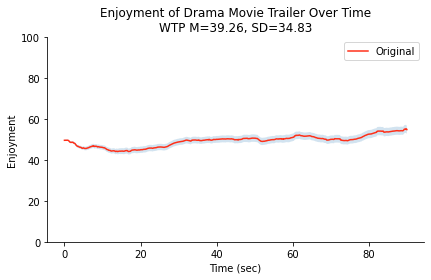

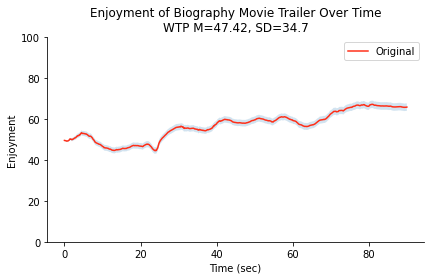

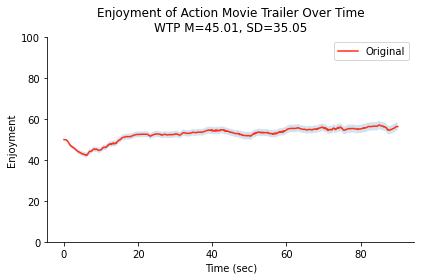

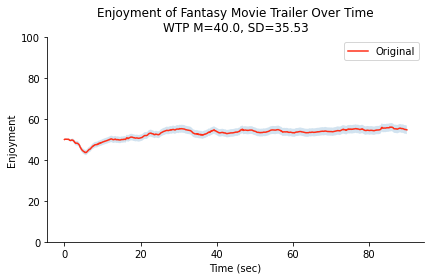

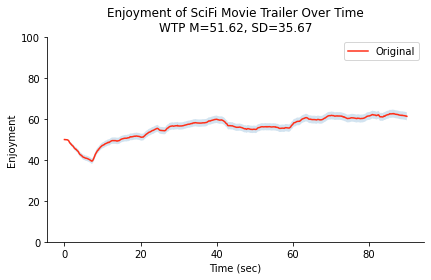

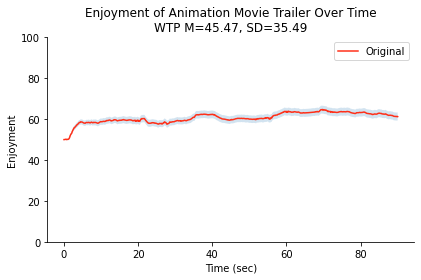

In [8]:

######################## PERFORM EXCLUSIONS ########################

def listify(row):
    row = str(row).split(',')
    row = [float(y) for y in row]

    return row


for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(listify, args=())
    estr = '4' if title not in ['Action', 'Adventure'] else '1'


# All passed attention checks
# Comprehension checks
data = data[(data['comp_check_1'] == 'Shazam! Fury of the Gods') & (data['comp_check_2'] == 'Enjoyment')]
print("Number of participants excluded from comprehension checks: ", before_exc - data.shape[0])

## Remove data with too few or many points, and exclude those who have the same enjoyments for more than 30 seconds
rms = []
for index, row in data.iterrows():
    for title in titles:
        if abs(len(row['{}Enjoyment'.format(title)]) - 900) > 300:
            rms.append(row['ResponseId'])

        if max([sum(1 for i in g) for k, g in groupby(row['{}Enjoyment'.format(title)])]) > 300:
            rms.append(row['ResponseId'])

        # Get the duration of which resolution the participant watched the video in
        state_changes = json.loads(row['{}StateChanges'.format(title)])
        playback_qualities = json.loads(row['{}PlaybackQualities'.format(title)])

        data.loc[index, '{}PlaybackQuality'.format(title)] = playback_qualities[0][0]
        data.loc[index, '{}StateChangeAmount'.format(title)] = len(state_changes)
        data.loc[index, '{}QualityChangeAmount'.format(title)] = len(playback_qualities)

rms = list(dict.fromkeys(rms))
print("Inactive participants: ", len(rms))
data = data[~data['ResponseId'].isin(rms)]

total = data.shape[0]
print("Number after exclusions: ", total)

data["age"] = pd.to_numeric(data["age"], errors='coerce')
print("Mean age: ", data[data["age"] < 100]["age"].mean())
print("% Female: ", str(data["gender"].value_counts()["Female"] / data.shape[0]))

def resample_time(row):
    return signal.resample(row, 900)


##  Resample the data to be 900 ms, and plot the graphs
for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(resample_time)
    estr = '4' if title not in ['Action', 'Adventure'] else '1'
    plot_lines(data.loc[:, '{}Enjoyment'.format(title)], title='{}'.format(title),
               wtp_mean=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).mean(), 2),
               wtp_std=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).std(), 2), mean=True)


In [9]:

if use_rpy2:
    # Linear regression to see whether different playback qualities and state changes affect WTP
    for title in titles:
        print(title, "State Change Amount")

        estr = '4' if title not in ['Action', 'Adventure'] else '1'
        robjects.globalenv['dataframe'] = data[
            ['{}_willing_{}'.format(title.lower(), estr), '{}StateChangeAmount'.format(title),
            '{}PlaybackQuality'.format(title), '{}QualityChangeAmount'.format(title)]]
        M = stats.lm(
            '{}_willing_{} ~ {}StateChangeAmount + {}QualityChangeAmount + {}PlaybackQuality'.format(title.lower(), estr,
                                                                                                    title, title, title),
            data=base.as_symbol('dataframe'))
        print(base.summary(M))

        # Clean dataframe since we do not need these columns now
        data = data.drop(columns=['{}StateChangeAmount'.format(title), '{}QualityChangeAmount'.format(title),
                                '{}PlaybackQuality'.format(title)])



In [ ]:
!pip list

In [ ]:

################ Calculate metrics for predicting enjoyments
xs = np.linspace(0, 90, num=900)


# Number of Peaks
def get_num_peaks(row):
    poly = np.polyfit(xs, row, fit_degree)
    poly_y = np.poly1d(poly)(xs)

    peaks, _ = signal.find_peaks(poly_y)
    return len(peaks)


# Number of Valleys
def get_num_valleys(row):
    poly = np.polyfit(xs, row, fit_degree)
    poly_y = np.poly1d(poly)(xs)

    # Find peaks of negative signal ---
    peaks, _ = signal.find_peaks(-poly_y)

    return len(peaks)


# Number of Extrema
def get_num_extrema(row):
    return get_num_peaks(row) + get_num_valleys(row)


def get_first_derivative(row):
    poly = np.polyfit(xs, row, fit_degree)
    return json.dumps(list(np.polyder(poly)))


def get_poly(row):
    return json.dumps(list(np.polyfit(xs, row, fit_degree)))


def get_best_degree(row, errors):
    for degree in range(1, 150):
        if errors.get(degree, None) is None:
            errors[degree] = []

        #plot_lines(row, "testing_{}".format(np.mean(row)), 10, 0)
        fit = np.polyfit(xs, row, degree)
        yfit = np.polyval(fit, xs)
        residual = np.sum((row - yfit) ** 2)
        errors[degree].append(residual)
        #errors[degree].append(np.sum(fit[1]))



errors = {}
## Save the polynomials for R
for title in titles:
    print(title)
    data.loc[:, '{}Enjoyment'.format(title)].apply(get_best_degree, errors=errors)
    data[title + '_first_derivative'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_first_derivative)
    data[title + '_equation'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_poly)
    data[title + '_number_peaks'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_peaks)
    data[title + '_number_valleys'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_valleys)
    data[title + '_number_extrema'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_extrema)

data.to_csv('./data/lifelines_cleaned_deg{}.csv'.format(fit_degree))


In [ ]:
## Convert cluster centers to polynomials

def get_poly(row, i):
    #plot_lines(row, "cluster_{}_{}".format(i, np.mean(row)), 0, 0)
    xs = np.linspace(0, 90, num=900)
    return json.dumps(list(np.polyfit(xs, row, fit_degree)))

cluster_centers = pd.read_csv('./data/cluster_centers.csv')
cluster_polynomials = {}

for i in range(0, 27):
    cluster_polynomials[i] = get_poly(np.asarray(cluster_centers[str(i)]), i)
    print(i)

print(cluster_polynomials)
cp_pd = pd.DataFrame.from_dict(cluster_polynomials, orient='index')
cp_pd.to_csv('./data/cluster_polynomials.csv')


In [ ]:
err_mean = []
err_sem = []
for degree, errs in errors.items():
    print("Error for degree {} is: ".format(degree), sum(errs) / len(errs))
    err_mean.append(sum(errs) / len(errs))
    err_sem.append(sem(errs))

In [ ]:
min(err_mean)

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_error_line(err_mean, err_sem):
    SMALL_SIZE = 13 * 9/10
    MEDIUM_SIZE = 20 * 9/10
    BIGGER_SIZE = 24 * 9/10

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE + 1)  # fontsize of the figure title


    xs = np.linspace(1, 149, num=149)
    plt.figure()

    plt.plot(xs, err_mean)
    plt.ylabel("Error", fontweight='bold')
    plt.xlabel("Degree", fontweight='bold')

    plt.tight_layout()


    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig("./plots/err.png", dpi=1000)

plot_error_line(err_mean, err_sem)

In [ ]:
 ################## FLATTEN THE DATA ##################
########### Run after running "calculate_predictors.R ###########
#    Input: dataframe with number of rows = n_subjects
#    Output: dataframe with number of rows = n_subjects * n_genres (=8)
data = pd.read_csv('./data/lifelines_w_features.csv')
include_points = True

df = None
count = 1


def flatten_data(data, count, df, include_points=False):
    # Split the columns, based on name
    for title in titles:
        a = data.filter(regex=(title))
        b = data.filter(regex=(title.lower()))

        acols = [c for c in a.columns][4:]
        bcols = [c for c in b.columns][5:]

        a = a[acols]
        b = b[bcols]

        X = pd.concat([a, b], axis=1)

        old_colnames = list(X.columns)
        new_colnames = {}

        if include_points:
            def listify(row):
                row = str(row).replace('[', '').replace(']', '').replace('\n', '').split(' ')
                row = [float(y) for y in row if y != '']

                return row

            X['points'] = data['{}Enjoyment'.format(title)]
            X.loc[:, 'points'] = X.loc[:, 'points'].apply(listify)

        for old in old_colnames:
            new_colnames[old] = old.lower().split(title.lower() + "_")[1]

            if 'willing' in new_colnames[old]:
                new_colnames[old] = new_colnames[old][:-2]

        X = X.rename(columns=new_colnames)
        X['genre'] = title

        X['subject'] = [c for c in range(1, data.shape[0] + 1)]
        X['movie_choice'] = data['movie_choice']
        count += 1

        if df is None:
            df = copy.deepcopy(X)
        else:
            df = pd.concat([df, X], axis=0)

    return df


df = flatten_data(data, count, df, include_points)
df = df.sort_values(by=['subject', 'genre'])


def get_token(row):
    return [token.pos_ for token in nlp(row)][0]


def get_tokens_sentences(row):
    return [token.pos_ for token in nlp(row)]


df.loc[:, 'word_tag'] = df.loc[:, 'word'].apply(get_token)

if include_points:
    df.to_csv('./data/data_long.csv')
else:
    df.to_csv('./data/data.csv')

In [ ]:
################## PLOTTING ALL PARTICIPANTS ##################

# Plot each participant separately

plots = {}

for title in titles:
    count = 1
    for index, row in data.iterrows():
        plot_lines(row['{}Enjoyment'.format(title)], str(count) + "_{}".format(title),
                   wtp_mean=row.filter(regex='{}_willing'.format(title).lower())[0], wtp_std=None,
                   word=row.filter(regex='{}_word'.format(title).lower())[0])
        count += 1


In [ ]:
# Concatenate vertically
def get_concat_v(im1, im2):
    if im2 is None:
        return im1
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst


# Concatenate horizontally
def get_concat_h(im1, im2):
    if im2 is None:
        return im1
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


# Concatanate all participant plots into one huge plot
himg2 = None
for title in ['Horror']:
    im2 = None
    for i in range(1, 234):
        img_file = glob.glob('./plots/individual/lifeline_{}_{}.png'.format(i, title))[0]
        print(img_file)
        im2 = get_concat_v(Image.open(img_file), im2)

    im2.save("{}_combined.jpg".format(title))
    himg2 = get_concat_h(im2, himg2)

himg2.save("all_combined.jpg".format(title))
